# SyncMCMC Tutorial

The following tutorial serves to illustrate proper implementation of SyncMCMC for inferring the flux normalization, self-absorption frequency, and characteristic electron frequency corresponding to synchrotron emission from a relativistic jet. These parameters, when combined with minimal energy equipartition arguments, allow for constraints on the total electron density and bulk Lortentz factor of the jet, as well as the minimum energy and physical source size.

In [15]:
%matplotlib inline
import sys
sys.path.append('/Users/Gandalf/SyncMCMC/syncmcmc')
from priorclasses import FluxFrequencyPriors, UniformPrior,FluxFrequencyPriorsCombinedSpectrum
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import emcee
import corner
import argparse
from runmcmc import run_PTmcmc
sns.set_style("white")

SyncMCMC executes simultaneous Parallel-Tempered Markov Chain Monte Carlo methods for four unique models. The output plot shows fits for all four models, where parameter estimates correspond to the maximum of the posterior probability density function. Parameter estimates for each model are saved to separate files. For an description of each model, please see the model.ipynb file.


SyncMCMC allows the user to input a number of parameters, such as lower and upper bounds for uniform priors on each parameter, and specify outputs, including corner plots and time series of the sampler chains. The data file must be specified when executing the script and should be titled accordingly (ie. "event_ndays") where ndays refers to the elapsed time since initial detection. 

       Usage: model.py [options] -i filename
    
       Outputs best fit parameters for F_v, v_a, and v_m and a plot of the fit.

       Options:

       -i     --input     Specify data file
       -r     --raw       Plot raw data
       -fp    --fprior    Speicify lower and upper bounds for prior on flux normalization factor (Default: 1:50)
       -vap   --vaprior   Specify lower and upper bounds for prior on self absorption frequency (Default 1E9:1E11)
       -vam   --vamprior  Specify lower and upper bounds for prior on characteristic frequency (Default 1E9:1E11)
       -lnfp  --lnfprior  Specify lower and upper bounds for prior on fractional amount by which variance is underestimated
       -t     --trace     Plot MCMC traces for F_v, v_a, v_m
       -c     --corner    Plot corner plots
       -F     --F_true    Specify true value for F_v
       -vat   --va_true   Specify true value for va
       -vmt   --vm_true   Specify true value for vm 

For example, the script can be called via:
    
        python ./run_analysis.py -i Sw1644+57_197days -t 
        
where the output will produce a plot of the best fit parameters as well as a time series of the sampler chains. 

The argument -r produces a plot of the raw data. 

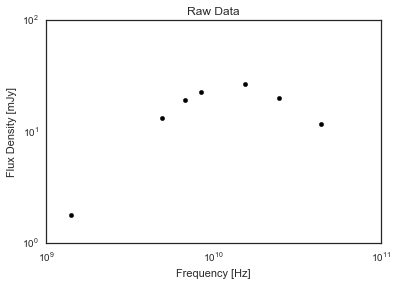

In [6]:
# Load data

flux = []
freqs = []
error = []

for line in open('syncmcmc/data/Sw1644+57_197days'):
   lines = line.strip()
   if not line.startswith("#"):
      columns = line.split(',')
      freqs.append(columns[0])
      flux.append(columns[1])
      error.append(columns[2].rstrip('\n'))

flux = np.array(flux).astype(float)
freqs = np.array(freqs).astype(float)
error = np.array(error).astype(float)

plt.scatter(freqs,flux,color='k')
plt.xscale('log')
plt.yscale('log')
plt.title('Raw Data')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Flux Density [mJy]')
plt.show()

The arguments -fp, -vap, and -vam specify the upper and lower bounds for priors on the flux normalization, self absorption frequency, and characteristic electron frequency respectively. As the frequencies are observable in the radio regime, 1 to a few hundred GHz are generally acceptable ranges. The flux normalization factor typically varies between 1 and 100 mJy. To pass these arguments:

        python ./run_analysis.py -i Sw1644+57_197days -fp 1 55 -vap 1E10 1E11 -vam 1E10 1E11
     
These arguments are optional. Default values are given by 1-50 for the flux and 1E9-1E11 for both break frequencies.

Required arguments include -i for the input file, and -Ft, -vat, and -vam, which are guess values for the flux normalization factor, self-absorption frequency, and characteristic frequency respectively. All other arguments are optional.

The script begins by defining each separate model and their respective likelihood functions. In each case, free parameters include the flux normalization factor F, the self-absorption frequency $\nu_a$, the characteristic frequency $\nu_m$, and the fractional amount by which the variances are underestimated, f. Model 4 includes an additionl parameter -- a second flux normalization factor.

In [16]:
### Synchrotron Models ###

# Define synchrotron spectrum for Model 1 

def spectrum(v,F_v,v_a,v_m):
    return F_v * (((v/v_a)**(-s_1*beta_1) + (v/v_a)**(-s_1*beta_2))**(-1./s_1)) * ((1 + (v/v_m)**(s_2*(beta_2-beta_3)))**(-1./s_2))


# Define synchrotron spectrum for Model 2 

def spectrum_2(v,F_v,v_a,v_m):
    phi = (v/v_m)
    return F_v * (((phi)**(2.)) * np.exp(- s_4 * phi**(2./3.)) + phi**(5./2.) ) * ((1 + (v/v_a)**(s_5*(beta5_1-beta5_2)))**(-1./s_5))


# Define synchrotron spectrum for Model 3

def weighted_spectrum(v,F_v,v_a,v_m):
    phi = (v/v_m)
    return ((v_m/v_a)**2. * (F_v * (((v/v_a)**(-s_1*beta_1) + (v/v_a)**(-s_1*beta_2))**(-1./s_1)) * ((1 + (v/v_m)**(s_2*(beta_2-beta_3)))**(-1./s_2))) + (v_a/v_m)**2. * F_v * ((((phi)**(2.)) * np.exp(- s_4 * phi**(2./3.)) + phi**(5./2.) ) * ((1 + (v/v_a)**(s_5*(beta5_1-beta5_2)))**(-1./s_5))))/((v_a/v_m)**2. + (v_m/v_a)**2.)


# Define synchrotron spectrum for Model 4

def comb_spectrum(v,F_v,F_2,v_a,v_m):
    phi = (v/v_m)
    return ((v_m/v_a)**2. * (F_v * (((v/v_a)**(-s_1*beta_1) + (v/v_a)**(-s_1*beta_2))**(-1./s_1)) * ((1 + (v/v_m)**(s_2*(beta_2-beta_3)))**(-1./s_2))) + (v_a/v_m)**2. * F_2 * ((((phi)**(2.)) * np.exp(- s_4 * phi**(2./3.)) + phi**(5./2.) ) * ((1 + (v/v_a)**(s_5*(beta5_1-beta5_2)))**(-1./s_5))))/((v_a/v_m)**2. + (v_m/v_a)**2.)



In [17]:
### Log likelihood functions ###

# Log likelihood for Model 1

def lnlike(theta, v, y, yerr):
    F_v,v_a,v_m,lnf = theta
    model = spectrum(v,F_v,v_a,v_m)
    inv_sigma2 = 1.0 / (yerr**2 + model**2 * np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))


# Log likelihood for Model 2

def lnlike_spec2(theta, v, y, yerr):
    F_v,v_a,v_m,lnf = theta
    model = spectrum_2(v,F_v,v_a,v_m)
    inv_sigma2 = 1.0 / (yerr**2 + model**2 * np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))


# Log likelihood for Model 3

def lnlike_spec3(theta, v, y, yerr):
    F_v,v_a,v_m,lnf = theta
    model = weighted_spectrum(v,F_v,v_a,v_m)
    inv_sigma2 = 1.0 / (yerr**2 + model**2 * np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))


# Log likelihood for Model 4

def lnlike_spec4(theta, v, y, yerr):
    F_v,F_v2,v_a,v_m,lnf = theta
    model = comb_spectrum(v,F_v,F_v2,v_a,v_m)
    inv_sigma2 = 1.0 / (yerr**2 + model**2 * np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))


We will also define known parameters here. For a description, please see model.ipynb.

In [23]:
### Define known parameters ### 


p = 2.5 
epsilon_e = 0.1 * (p-2.)/(p-1.)
epsilon_b = 0.1


# Spectral slopes

beta_1 = 2.
beta_2 = 1./3.
beta_3 = (1.-p)/2.
beta5_1 = 5.0/2.0
beta5_2 = (1.0 - p)/2.0



# Shape of spectrum at each break

s_1 = 1.5
s_2 = (1.76 + 0.05*p)
s_3 = (0.8 - 0.03*p)
s_4 = 3.63 * p - 1.60
s_5 = 1.25 - 0.18 * p


Next, uniform priors are defined for each model. In the case of model 4, there are 5 free parameters, and thus, we define a unique set of priors.

In [18]:
# Define priors

priors = FluxFrequencyPriors(UniformPrior(1.,55.),
          UniformPrior(1E8,1E11),
          UniformPrior(1E8,1E11), 
          UniformPrior(-3,0.01))

# Define priors for model 4

priors_spec4 = FluxFrequencyPriorsCombinedSpectrum(UniformPrior(1.,55.),
          UniformPrior(1.,55.),
          UniformPrior(1E8,1E11),
          UniformPrior(1E8,1E11), 
          UniformPrior(-3,0.01))

The "guess parameters" which are passed as arguments to the script serve to initilaze the location of our walkers.

In [21]:
# Define number of dimensions and number of walkers

ndim, nwalkers = 4, 100

# Define initial positions of walkers in phase space for models 1, 2, and 3

frand = np.random.normal(loc=36,size=nwalkers,scale=0.1)
frand_2 = np.random.normal(loc=36,size=nwalkers,scale=0.1)
varand = np.random.normal(loc=1e10,size=nwalkers,scale=1.E3)
vmrand = np.random.normal(loc=1e10,size=nwalkers,scale=1.E3)
yerrand = np.random.normal(loc=-0.7,size=nwalkers,scale=0.1)

pos = np.column_stack((frand,varand,vmrand,yerrand)) 
pos_add_dim = np.expand_dims(pos,axis=0)
final_pos = np.repeat(pos_add_dim, 5, axis=0)


# Define initial positions for spectrum 4 walkers

pos_spec4 = np.column_stack((frand,frand_2,varand,vmrand,yerrand)) 
pos_add_dim_spec4 = np.expand_dims(pos_spec4,axis=0)
final_pos_spec4 = np.repeat(pos_add_dim_spec4, 5, axis=0)

Given the log likelihoods and our priors, we can now unleash our walkers and sample the posterior, which we do for each model.

In [24]:
# Run MCMC sampler for each model

sampler, sams = run_PTmcmc(5,lnlike, priors, final_pos, ndim, nwalkers, logargs=[freqs,flux,error])

sampler_spec2, sams_spec2 = run_PTmcmc(5,lnlike_spec2, priors, final_pos, ndim, nwalkers, logargs=[freqs,flux,error])

sampler_spec3, sams_spec3 = run_PTmcmc(5,lnlike_spec3, priors, final_pos, ndim, nwalkers, logargs=[freqs,flux,error])

sampler_spec4, sams_spec4 = run_PTmcmc(5,lnlike_spec4, priors_spec4, final_pos_spec4, 5, nwalkers, logargs=[freqs,flux,error])

We can take a look at the time series traces corresponding to a particular model (if we've passed the -t argument when calling the script).

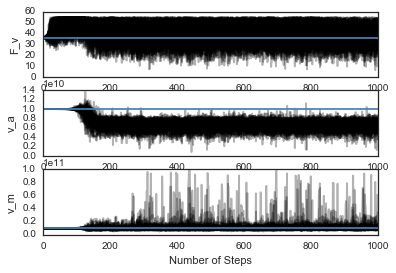

In [26]:
plt.subplot(3,1,1)
plt.plot(sampler.chain[0, :, :, 0].T,color="k", alpha=0.3)
plt.axhline(36, color='#4682b4')
plt.ylabel('F_v')
plt.xlabel('Number of Steps')

plt.subplot(3,1,2)
plt.plot(sampler.chain[0,:, :, 1].T, color="k", alpha=0.3)
plt.axhline(1e10, color='#4682b4')
plt.ylabel('v_a')
plt.xlabel('Number of Steps')

plt.subplot(3,1,3)
plt.plot(sampler.chain[0,:, :, 2].T, color="k", alpha=0.3)
plt.axhline(1e10, color='#4682b4')
plt.ylabel('v_m')
plt.xlabel('Number of Steps')

We find that the values converge, or "burn in" after about 200 steps, so we will go ahead and discard the first 300 steps (we'll play it safe).

In [28]:
# Burn off initial steps
samples = sampler.chain[0,:, 300:, :].reshape((-1, ndim))

samples_spec2 = sampler_spec2.chain[0,:, 300:, :].reshape((-1, ndim))

samples_spec3 = sampler_spec3.chain[0,:, 300:, :].reshape((-1, ndim))

samples_spec4 = sampler_spec4.chain[0,:, 300:, :].reshape((-1, 5))


Similarly, we can take a look at the one and two dimensional projections of our posterior probability distributions. The histograms along the diagonal represent the marginalized distributions for each individual parameter. The other plots illustrate the covariance among the parameters.

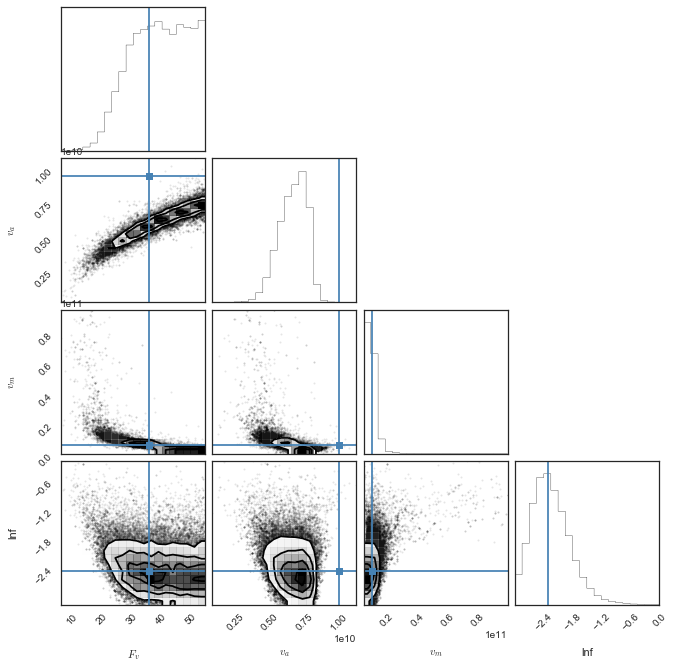

In [31]:
fig = corner.corner(samples, labels=["$F_v$", "$v_a$", "$v_m$", "lnf"],truths=[36,1e10,1e10, np.log(0.1)])

Now that the logistics are squared away, let's get what we came here for. Our parameter estimates. For now, we'll take the values corresponding to the maximum of the posterior. 

In [53]:
# Find values corresponding to maximum of posterior for each model

maxprobs = sampler.chain[0,...][np.where(sampler.lnprobability[0,...] == sampler.lnprobability[0,...].max())].mean(axis=0)

maxprobs_spec2 = sampler_spec2.chain[0,...][np.where(sampler_spec2.lnprobability[0,...] == sampler_spec2.lnprobability[0,...].max())].mean(axis=0)

maxprobs_spec3 = sampler_spec3.chain[0,...][np.where(sampler_spec3.lnprobability[0,...] == sampler_spec3.lnprobability[0,...].max())].mean(axis=0)

maxprobs_spec4 = sampler_spec4.chain[0,...][np.where(sampler_spec4.lnprobability[0,...] == sampler_spec4.lnprobability[0,...].max())].mean(axis=0)


F_mcmc, va_mcmc, vm_mcmc, lnf_mcmc = maxprobs
F_spec2_mcmc, va_spec2_mcmc, vm_spec2_mcmc, lnf_spec2_mcmc = maxprobs_spec2
F_spec3_mcmc, va_spec3_mcmc, vm_spec3_mcmc, lnf_spec3_mcmc = maxprobs_spec3
F_spec4_mcmc, F2_spec4_mcmc,va_spec4_mcmc, vm_spec4_mcmc, lnf_spec4_mcmc = maxprobs_spec4

# Print results
print ("F_v_spec1 = %s" % F_mcmc)
print ("v_a_spec1 = %s" % va_mcmc)
print ("v_m_spec1 = %s" % vm_mcmc)
print()
print ("F_v_spec2 = %s" % F_spec2_mcmc)
print ("v_a_spec2 = %s" % va_spec2_mcmc)
print ("v_m_spec2 = %s" % vm_spec2_mcmc)
print()
print ("F_v_spec3 = %s" % F_spec3_mcmc)
print ("v_a_spec3 = %s" % va_spec3_mcmc)
print ("v_m_spec3 = %s" % vm_spec3_mcmc)
print()
print ("F_v_spec4 = %s" % F_spec4_mcmc)
print ("F2_v_spec4 = %s" % F2_spec4_mcmc)
print ("v_a_spec4 = %s" % va_spec4_mcmc)
print ("v_m_spec4 = %s" % vm_spec4_mcmc)

F_v_spec1 = 54.1913198803
v_a_spec1 = 7983050720.2
v_m_spec1 = 7147047568.04

F_v_spec2 = 54.7733267721
v_a_spec2 = 6112113756.35
v_m_spec2 = 6272267846.78

F_v_spec3 = 42.7218519845
v_a_spec3 = 6563700443.47
v_m_spec3 = 9701232484.06

F_v_spec4 = 50.4452364158
F2_v_spec4 = 11.6041326359
v_a_spec4 = 6770175665.24
v_m_spec4 = 9117092030.67


Finally, we can plot each of our models with the parameter estimates that we found above. 

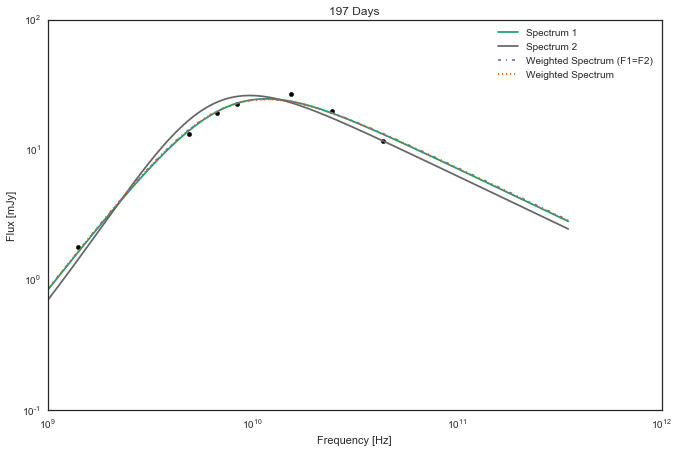

In [50]:
v_range = np.linspace(1E9,350E9,1E4)
plt.figure(figsize=(11,7))
plt.scatter(freqs,flux,color='k')
plt.plot(v_range,spectrum(v_range,F_mcmc,va_mcmc,vm_mcmc),color='#1b9e77',label='Spectrum 1')
plt.plot(v_range,spectrum_2(v_range,F_spec2_mcmc,va_spec2_mcmc,vm_spec2_mcmc),color='#666666',label='Spectrum 2')
plt.plot(v_range,weighted_spectrum(v_range,F_spec3_mcmc,va_spec3_mcmc,vm_spec3_mcmc),ls='-.',color='#7570b3',label='Weighted Spectrum (F1=F2)')
plt.plot(v_range,comb_spectrum(v_range,F_spec4_mcmc,F2_spec4_mcmc,va_spec4_mcmc,vm_spec4_mcmc),ls=':',color='#d95f02',label='Weighted Spectrum')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('197 Days')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Flux [mJy]')
plt.show()


We can see that Spectrum 2 does a poor job of fitting the parameters. This is indeed consistent with the fact that Spectrum 2 assumes we are in a later epoch (one in which $\nu_m$ < $\nu_a$), when our MCMC parameter estimates have confirmed that we are not. On the other hand, the other three models do a similar job of characterizing the spectrum. The fact that the fits are so consistent suggests that we are still firmly rooted in an epoch in which $\nu_m$ dominates. 